In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

sales = pd.read_csv('train.csv')
store = pd.read_csv('store.csv')

# bring it weather information (rain, temperature, sunset time, snowing, wind speed)

/Users/Arek/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
store.isna().sum() # Some NaNs in Competition opening date and Promo2 participation. 
pd.set_option('display.max_columns', None)

In [3]:
# store wrangling
store.columns = list(map(lambda x: x.lower(), store.columns)) # Lowercase first

# For Promo2 - not much can be done if half data is missing. Fill with 0
store['promo2sinceweek'].fillna(0, inplace=True)
store['promo2sinceyear'].fillna(0, inplace=True)
store['promointerval'].fillna(0, inplace=True)

# Encode PromoInterval
store['promojan'] = np.where(store['promointerval'] == 'Jan,Apr,Jul,Oct', 1, 0) 
store['promofeb'] = np.where(store['promointerval'] == 'Feb,May,Aug,Nov', 1, 0) 
store['promomar'] = np.where(store['promointerval'] == 'Mar,Jun,Sept,Dec', 1, 0) 
store['promoapr'] = np.where(store['promointerval'] == 'Jan,Apr,Jul,Oct', 1, 0) 
store['promomay'] = np.where(store['promointerval'] == 'Feb,May,Aug,Nov', 1, 0) 
store['promojun'] = np.where(store['promointerval'] == 'Mar,Jun,Sept,Dec', 1, 0) 
store['promojul'] = np.where(store['promointerval'] == 'Jan,Apr,Jul,Oct', 1, 0) 
store['promoaug'] = np.where(store['promointerval'] == 'Feb,May,Aug,Nov', 1, 0) 
store['promosep'] = np.where(store['promointerval'] == 'JMar,Jun,Sept,Dec', 1, 0) 
store['promooct'] = np.where(store['promointerval'] == 'Jan,Apr,Jul,Oct', 1, 0) 
store['promonov'] = np.where(store['promointerval'] == 'Feb,May,Aug,Nov', 1, 0) 
store['promodec'] = np.where(store['promointerval'] == 'Mar,Jun,Sept,Dec', 1, 0) 

if 'storetype' in store.columns:
    store = pd.concat([store,pd.get_dummies(store['storetype'])], axis = 1).drop(['storetype'], axis = 1)
if 'assortment' in store.columns:
    store = pd.concat([store,pd.get_dummies(store['assortment'])], axis = 1).drop(['assortment'], axis = 1)
if 'promointerval' in store.columns:
    store = store.drop('promointerval', axis = 1)
    
store_with_competition_dates = store[store['competitionopensincemonth'].notna()]

store['competitionopensincemonth'] = store['competitionopensincemonth'].fillna(np.mean(store['competitionopensincemonth'])) # might fill with mean and just try to estimate the year
store['competitiondistance'] = store['competitiondistance'].fillna(np.mean(store['competitiondistance'])) # might fill with mean

In [4]:
# Create model 

y = store_with_competition_dates['competitionopensinceyear']
X = store_with_competition_dates.drop(['competitionopensinceyear','store'], axis = 1)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors = 1)
KNN.fit(X_scaled,y)
KNN.score(X_scaled,y)

0.9934296977660972

In [5]:
# Use model to predict competition open year

X = store.drop(['competitionopensinceyear', 'store'], axis = 1)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

predicted_year = pd.Series(KNN.predict(X_scaled),name='predicted_year')

store = pd.concat([store,predicted_year],axis=1)

In [6]:
store['competitionopensinceyear'] =  np.where(store['competitionopensinceyear'].isna(), store['predicted_year'], store['competitionopensinceyear'])
store = store.drop('predicted_year', axis = 1)

store.columns = ['store', 'competitiondistance', 'competitionopensincemonth',
       'competitionopensinceyear', 'promo2', 'promo2sinceweek',
       'promo2sinceyear', 'promojan', 'promofeb', 'promomar', 'promoapr',
       'promomay', 'promojun', 'promojul', 'promoaug', 'promosep', 'promooct',
       'promonov', 'promodec', 'store_type_a', 'store_type_b', 'store_type_c', 'store_type_d', 'assortment_a', 'assortment_b', 'assortment_c']

In [7]:
# Let's start with sales

sales.columns = list(map(lambda x: x.lower(), sales.columns)) # Lowercase first

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sales['stateholiday'].unique()

def clean_stateholiday(x):
    if x in ['0',0]:
        return 0
    else:
        return x
sales['stateholiday'] = sales['stateholiday'].apply(clean_stateholiday)

if 'stateholiday' in sales.columns:
    sales = pd.concat([sales,pd.get_dummies(sales['stateholiday'])], axis = 1).drop(['stateholiday'], axis = 1)

In [9]:
sales['date'] = pd.to_datetime(sales['date'])

sales['day'] = sales['date'].apply(lambda x: x.day)
sales['month'] = sales['date'].apply(lambda x: x.month)
sales['year'] = sales['date'].apply(lambda x: x.year)
sales = sales.drop('date', axis = 1)

In [10]:
sales = sales[[col for col in sales.columns if col not in ['dayofweek','sales','customers']] + ['dayofweek'] + ['sales'] + ['customers']]
sales.columns = ['store','open','promo','schoolholiday','stateholiday_0','stateholiday_a','stateholiday_b','stateholiday_c','day','month','year','dayofweek','sales','customers']

In [11]:
# Finally joining the data together

cleaned = sales.merge(store, on = 'store')
cleaned = cleaned[[col for col in cleaned.columns if col not in ['sales','customers']]+ ['sales'] + ['customers']]


In [12]:
def conditions(x):
    if (x['month'] in [1,4,7,10]) and (x['promojan'] == 1):
        return 1
    elif (x['month'] in [2,5,8,11]) and (x['promofeb'] == 1):
        return 1
    elif (x['month'] in [3,6,9,12]) and (x['promomar'] == 1):
        return 1
    else:
        return 0

cleaned['promoboost'] = cleaned.apply(conditions, axis=1)

cleaned = cleaned.drop(['promojan', 'promofeb', 'promomar', 'promoapr','promomay','promojun','promojul','promoaug','promosep','promooct','promonov', 'promodec'],axis = 1)

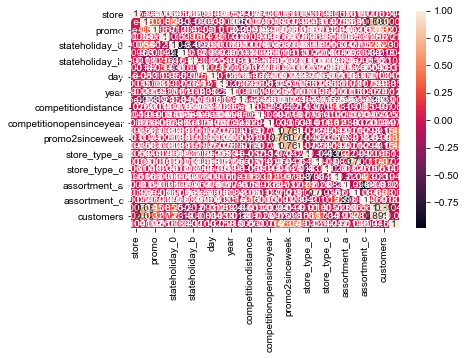

In [13]:
correlation_matrix = cleaned.corr()
sns.heatmap(correlation_matrix, annot=True)
sns.set(rc={'figure.figsize':(20,20)})
plt.show()

In [18]:
cleaned

,store,open,promo,schoolholiday,stateholiday_0,stateholiday_a,stateholiday_b,stateholiday_c,day,month,year,dayofweek,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,store_type_a,store_type_b,store_type_c,store_type_d,assortment_a,assortment_b,assortment_c,sales,customers,promoboost
0,1,1,1,1,1,0,0,0,31,7,2015,5,1270.0,9.000000,2008.0,0,0.0,0.0,0,0,1,0,1,0,0,5263,555,0
1,1,1,1,1,1,0,0,0,30,7,2015,4,1270.0,9.000000,2008.0,0,0.0,0.0,0,0,1,0,1,0,0,5020,546,0
2,1,1,1,1,1,0,0,0,29,7,2015,3,1270.0,9.000000,2008.0,0,0.0,0.0,0,0,1,0,1,0,0,4782,523,0
3,1,1,1,1,1,0,0,0,28,7,2015,2,1270.0,9.000000,2008.0,0,0.0,0.0,0,0,1,0,1,0,0,5011,560,0
4,1,1,1,1,1,0,0,0,27,7,2015,1,1270.0,9.000000,2008.0,0,0.0,0.0,0,0,1,0,1,0,0,6102,612,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989063,1115,1,0,1,1,0,0,0,5,1,2013,6,5350.0,7.224704,2013.0,1,22.0,2012.0,0,0,0,1,0,0,1,4771,339,0
989064,1115,1,0,1,1,0,0,0,4,1,2013,5,5350.0,7.224704,2013.0,1,22.0,2012.0,0,0,0,1,0,0,1,4540,326,0
989065,1115,1,0,1,1,0,0,0,3,1,2013,4,5350.0,7.224704,2013.0,1,22.0,2012.0,0,0,0,1,0,0,1,4297,300,0
989066,1115,1,0,1,1,0,0,0,2,1,2013,3,5350.0,7.224704,2013.0,1,22.0,2012.0,0,0,0,1,0,0,1,3697,305,0


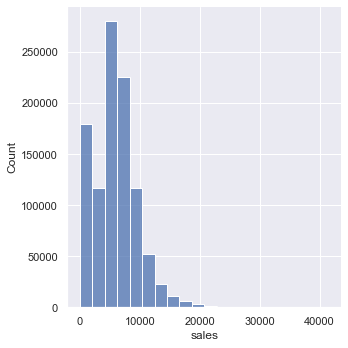

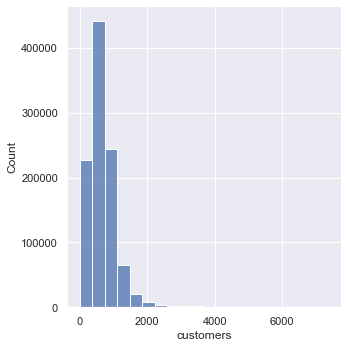

14076 elements to be removed from sales, 1.4 %
24691 elements to be removed from customers, 2.4 %


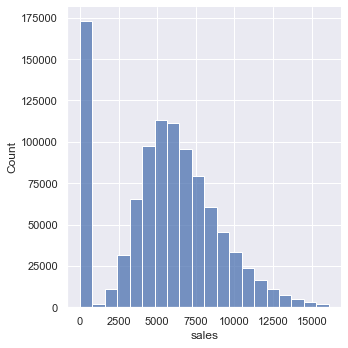

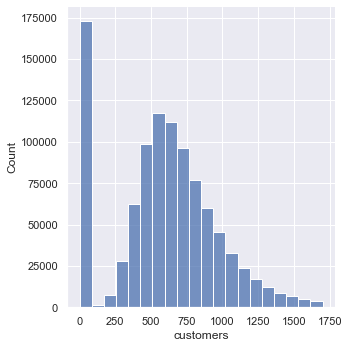

In [14]:
sns.displot(cleaned['sales'], bins = 20)
plt.show()
sns.displot(cleaned['customers'], bins = 20)
plt.show()

iqr_sales = np.percentile(cleaned['sales'],75) - np.percentile(cleaned['sales'],25)
upper_limit_sales = np.percentile(cleaned['sales'],75) + 2*iqr_sales
extra1 = cleaned[cleaned['sales'] > upper_limit_sales] 

iqr_customers = np.percentile(cleaned['customers'],75) - np.percentile(cleaned['customers'],25)
upper_limit_customers = np.percentile(cleaned['customers'],75) + 2*iqr_customers
extra2 = cleaned[cleaned['customers'] > upper_limit_customers] 

print(len(extra1),'elements to be removed from sales,', round(100*len(extra1)/len(cleaned),1),'%')
print(len(extra2),'elements to be removed from customers,', round(100*len(extra2)/len(cleaned),1),'%')


# removing these after checking it is safe
cleaned = cleaned[cleaned['sales'] < upper_limit_sales]
cleaned = cleaned[cleaned['customers'] < upper_limit_customers]

cleaned.reset_index(drop=True, inplace=True)
sns.displot(cleaned['sales'], bins = 20)
plt.show()
sns.displot(cleaned['customers'], bins = 20)
plt.show()


In [15]:
# Test/train split 

y = cleaned[['sales','customers']]
X = cleaned.drop(['sales', 'customers'], axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 31337)

y1_test = y_test['sales']
y1_train = y_train['sales']
y2_test = y_test['customers']
y2_train = y_train['customers']

In [16]:
def multi_tester_v01(X_train,y_train,X_test,y_test):
    choice = input('Select the tests you want to run: 1/0 KNeighbors, 1/0 Linear, 1/0 MLPRegressor (e.g. 111 to run all three tests)')
    
    if choice[0] == '1': 
        # --- KneighborsRegressor
        from sklearn.neighbors import KNeighborsRegressor

        KNN = KNeighborsRegressor(n_neighbors = 10, weights='distance', algorithm='brute', p = 1)
        KNN.fit(X_train, y_train)
        print('KNeighborsRegressor score is:', round(KNN.score(X_test, y_test),2))
     
    if choice[1] == '1':
        # --- Linear Modeal
        from sklearn import linear_model

        lm = linear_model.LinearRegression()
        lm.fit(X_train,y_train)

        from sklearn.metrics import r2_score

        predictions_test = lm.predict(X_test)
        r2 = r2_score(y_test, predictions_test)
        print('Linear Model R2 score is:',round(r2,2))

    if choice[2] == '1':          
        # --- MLPRegressor
        from sklearn.neural_network import MLPRegressor

        regr = MLPRegressor(random_state=1, max_iter=1000).fit(X_train, y_train)
        print('MLPRegressor score is:', round(regr.score(X_test, y_test),2)) 

In [19]:
multi_tester_v01(X_train,y1_train,X_test,y1_test)

Select the tests you want to run: 1/0 KNeighbors, 1/0 Linear, 1/0 MLPRegressor (e.g. 111 to run all three tests) 111


KNeighborsRegressor score is: 0.78
Linear Model R2 score is: 0.64


/Users/Arek/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor score is: 0.74


In [20]:
predictions_test = KNN.predict(X_test)

from sklearn.metrics import r2_score

predictions_test = lm.predict(X_test)
r2 = r2_score(y1_test, predictions_test)
print('R2:',round(r2,2))

#6.2 MSE

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y1_test,predictions_test)
print('MSE:',round(MSE,1))

#6.3 RMSE

import numpy as np

RMSE = np.sqrt(mean_squared_error(y1_test,predictions_test))
print('RMSE:',round(RMSE,1))

#6.4 RMSPE
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

print('RMSPE:',round(rmspe(y1_test, predictions_test),1))

#6.5 MAE

from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y1_test, predictions_test)
print('MAE:',round(MAE,1))

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 26 while Y.shape[1] == 24